In [21]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

In [22]:
os.listdir()

['optimiation3.pdf',
 'README.md',
 'optimiation2.pdf',
 'optimiation.pdf',
 'Papers',
 'bayesopt2.py',
 '__pycache__',
 'optimiation1.pdf',
 'UpdateConfirmation.ipynb',
 'bayesopt.py',
 'GPUpdating.ipynb',
 '.vscode',
 'locs.pkl',
 '.git',
 'AcquiringExample.ipynb',
 'StochasticProcesses',
 'vals.pkl',
 '.gitignore',
 '.ipynb_checkpoints']

In [23]:
with open("locs.pkl", "rb") as f:
    locs = pickle.load(f)
with open("vals.pkl", "rb") as f:
    vals = pickle.load(f)

In [68]:
def squared_exponential_kernel(x1, x2, length_scale=1.0, stdev=1.0):
    sq_distance = (x1[:, None] - x2[None, :]) ** 2
    return stdev**2 * np.exp(-0.5 * sq_distance/(length_scale ** 2))

kernel = lambda x1, x2: squared_exponential_kernel(x1, x2, length_scale=0.3)

In [69]:
X_domain = np.linspace(0, 5, 201)
mu_domain = np.zeros_like(X_domain)

X_obs = np.array(locs)
y = np.array(vals)
mu_obs = np.zeros_like(locs)

Sigma_ff = kernel(X_domain, X_domain)
Sigma_yy = kernel(X_obs, X_obs)

Sigma_fy_T = kernel(X_domain, X_obs)

In [70]:
posterior_mean = mu_domain + Sigma_fy_T @ np.linalg.inv(Sigma_yy) @ (y - mu_obs)

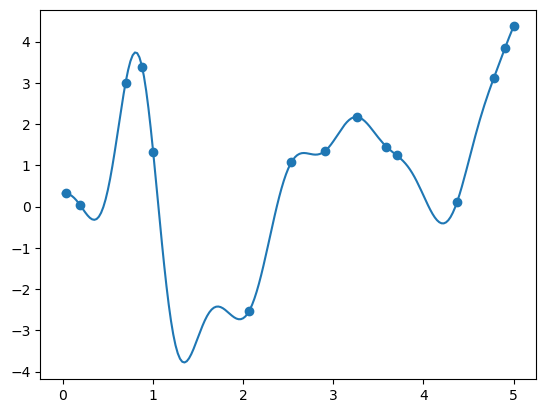

In [71]:
plt.plot(X_domain, posterior_mean)
plt.scatter(locs, vals)
plt.show()

In [47]:
import numpy as np
from scipy.special import kv, gamma

def _to_2d_column(x):
    x = np.asarray(x, dtype=float)
    return x.reshape(-1, 1) if x.ndim == 1 else x

def _pairwise_scaled_distances(x1, x2, length_scale):
    x1 = _to_2d_column(x1)
    x2 = _to_2d_column(x2)
    ls = np.asarray(length_scale, dtype=float)
    if ls.ndim == 0:
        ls = np.full(x1.shape[1], ls)
    # scale each dimension by its length scale
    x1s = x1 / ls
    x2s = x2 / ls
    return np.sqrt(((x1s[:, None, :] - x2s[None, :, :]) ** 2).sum(axis=2))

def matern_kernel(x1, x2, length_scale=1.0, variance=1.0, nu=1.5):
    """
    Matérn kernel between x1 and x2. Works with 1D arrays (n,) or 2D (n,d).
    length_scale can be a float or an array of shape (d,).
    """
    r = _pairwise_scaled_distances(x1, x2, length_scale)
    r = np.maximum(r, 1e-12)  # avoid divide-by-zero in general-ν formula

    if nu == 0.5:  # exponential
        K = variance * np.exp(-r)

    elif nu == 1.5:
        z = np.sqrt(3.0) * r
        K = variance * (1.0 + z) * np.exp(-z)

    elif nu == 2.5:
        z = np.sqrt(5.0) * r
        K = variance * (1.0 + z + (z ** 2) / 3.0) * np.exp(-z)

    else:
        z = np.sqrt(2.0 * nu) * r
        K = variance * (2.0 ** (1.0 - nu)) / gamma(nu) * (z ** nu) * kv(nu, z)
        # fix exact diagonals to variance (where r==0 before the clamp)
        if x1 is x2 or (np.ndim(x1) == np.ndim(x2) and np.array_equal(np.asarray(x1), np.asarray(x2))):
            np.fill_diagonal(K, variance)

    return K


In [48]:
kernel2 = lambda x1, x2: matern_kernel(x1, x2)

In [49]:
X_domain = np.linspace(0, 5, 201)
mu_domain = np.zeros_like(X_domain)

X_obs = np.array(locs)
y = np.array(vals)
mu_obs = np.zeros_like(locs)

Sigma_ff = kernel2(X_domain, X_domain)
Sigma_yy = kernel2(X_obs, X_obs)

Sigma_fy_T = kernel2(X_domain, X_obs)

In [50]:
posterior_mean = mu_domain + Sigma_fy_T @ np.linalg.inv(Sigma_yy) @ (y - mu_obs)

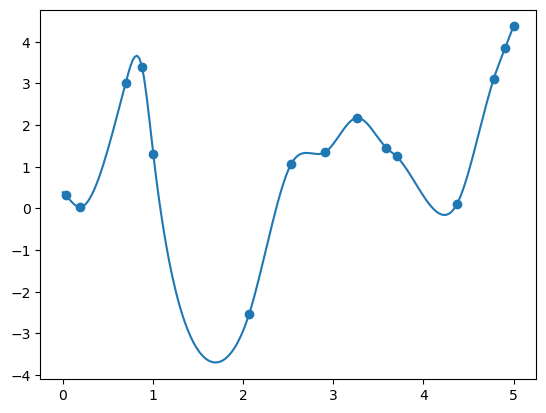

In [51]:
plt.plot(X_domain, posterior_mean)
plt.scatter(locs, vals)
plt.show()